# %% [markdown]

 # Augur || 寻找最先对实验条件做出响应的细胞亚群、基因

In [ ]:
# %%

import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import os

os.environ["PYTHONWARNINGS"] = "ignore"

In [ ]:
# %%

# 设置参数
import matplotlib as mpl
import pertpy as pt
import scanpy as sc

# 设置matplotlib参数
mpl.rcParams["pdf.fonttype"] = 42  # 保留字体

# 设置scanpy参数
sc.settings.verbosity = 0  # 4 输出细节
sc.settings.n_jobs = -1  # 使用所有核心
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=600,
    facecolor="white",
    frameon=False,  # 移除框架
)

In [ ]:
# %%

# 配置变量
# 注释列名称
ANNO_COL = "celltypist_cell_label_fine"

# 输入文件路径
INPUT_FILE = (
    "results/find_markers/anndata_find_markers_celltypist_harmony_celltypist.h5ad"
)

# 条件列名称
GROUP_COL = "group"  # 在原始数据中


# 原始数据中的对照和处理条件标签
CTRL_LABEL = "CNL"
STIM_LABEL = "CCL"

# 设置Augur参数
SUBSAMPLE_SIZE = 50  # 子样本大小
N_THREADS = 40  # 线程数量
SELECT_VARIANCE_FEATURES = False  # 是否选择方差特征
SPAN = 0.75  # 平滑因子，1表示不平滑
KEY_ADDED = "augurpy_results"  # 结果存储的键名
RANDOM_STATE = 123  # 随机种子

# 输出文件名
LOLLIPOP_FIG = "figures/14-细胞类型优先级-Augur-1.pdf"
IMPORTANT_FEATURES_FIG = "figures/14-细胞类型优先级-Augur-2.pdf"
AUGUR_ALL_CSV = "./table/augur_all.csv"
AUGUR_SUMMARY_CSV = "./table/augur_summary.csv"
FEATURE_IMPORTANCES_CSV = "./table/augur_feature_importances.csv"
FEATURES_IMPORTANCES_CSV = "./table/augur_topn_features_importances.csv"

In [ ]:
# %%

# 读入数据
adata = sc.read("../../results/anndata_annotation_harmony_celltypist.h5ad")
# 使用原始数据
adata_raw = adata.raw.to_adata()
adata_raw.obs = adata.obs
adata = adata_raw

In [ ]:
# %%

# 打印条件标签以确认
print("条件标签：", adata.obs[GROUP_COL].unique())

条件标签： ['CCL', 'CNL']
Categories (2, object): ['CCL', 'CNL']


In [ ]:
# %%

# 统计每个条件下的细胞类型计数
print(adata.obs.groupby(GROUP_COL)[ANNO_COL].value_counts())

group  celltypist_cell_label_fine
CCL    T cells                       15208
       Plasma cells                  13504
       Macrophages                    3238
       B cells                        2352
       Mast cells                      803
       Monocytes                       460
       ILC                             308
       DC                              208
       pDC                             151
CNL    Plasma cells                  18803
       T cells                        5061
       B cells                        2697
       Mast cells                      777
       Macrophages                     392
       ILC                             183
       Monocytes                       115
       pDC                              59
       DC                               35
Name: count, dtype: int64


In [ ]:
# %%

# 创建Augur实例
ag_rfc = pt.tl.Augur("random_forest_classifier")

In [ ]:
# %%

# 加载数据到Augur所需的格式
loaded_data = ag_rfc.load(
    adata,
    label_col=GROUP_COL,
    cell_type_col=ANNO_COL,
    condition_label=CTRL_LABEL,
    treatment_label=STIM_LABEL,
)
print(loaded_data)

• Filtering samples with CNL and CCL labels.
AnnData object with n_obs × n_vars = 64354 × 17065
    obs: 'C0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_antibody', 'nFeature_antibody', 'patients', 'sampletag', 'organs', 'percent.mt', 'percent.ribo', 'log10GenesPerUMI', 'batch', 'integrated_snn_res.0.5', 'seurat_clusters', 'samples', 'doublet.score', 'predicted.doublet', 'cluster', 'doublet', 'patients_organ', 'sample', 'label', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'mt_outlier', 'discard', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_0_25', 'leiden_0_5', 'leide

In [ ]:
# %%

# 运行Augur预测
v_adata, v_results = ag_rfc.predict(
    loaded_data,
    subsample_size=SUBSAMPLE_SIZE,
    n_threads=N_THREADS,
    select_variance_features=SELECT_VARIANCE_FEATURES,
    span=SPAN,
    key_added=KEY_ADDED,
    random_state=RANDOM_STATE,
)

Output()

! Data not normalized. Normalizing now using scanpy log1p normalize.


! Data not normalized. Normalizing now using scanpy log1p normalize.


! Data not normalized. Normalizing now using scanpy log1p normalize.


! Data not normalized. Normalizing now using scanpy log1p normalize.


! Skipping DC cell type - the number of samples for at least one class type is less than subsample size 50.


! Data not normalized. Normalizing now using scanpy log1p normalize.


! Data not normalized. Normalizing now using scanpy log1p normalize.


FileNotFoundError: [Errno 2] No such file or directory: 'figures/14-细胞类型优先级-Augur-1.pdf'

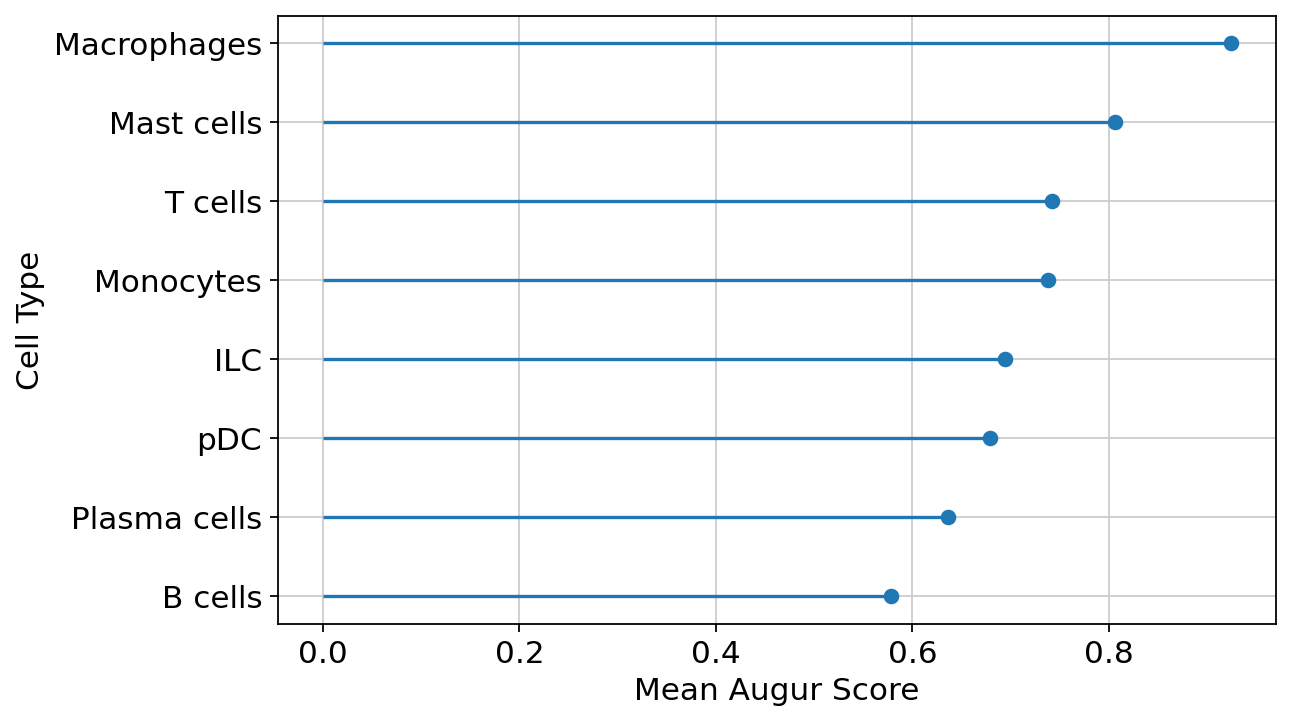

In [ ]:
# %%

# 绘制lollipop图
lollipop = ag_rfc.plot_lollipop(
    v_results,
    key=KEY_ADDED,
    return_fig=True,
)
lollipop.set_size_inches(8, 5)  # 设置图像尺寸

# 保存图像
lollipop.savefig(LOLLIPOP_FIG, dpi=300, bbox_inches="tight")

In [ ]:
# %%

# 保存结果到CSV文件
v_results["full_results"].to_csv(AUGUR_ALL_CSV, index=True)
v_results["summary_metrics"].to_csv(AUGUR_SUMMARY_CSV, index=True)

: 

In [ ]:
# %%

# 计算UMAP并绘制Augur得分
sc.pp.neighbors(v_adata, random_state=RANDOM_STATE)
sc.tl.umap(v_adata, random_state=RANDOM_STATE)

sc.pl.umap(
    adata=v_adata,
    color=["augur_score"],
    wspace=0.2,
    save="_augur_score.pdf",
    ncols=2,
    cmap="Reds",
)

: 

In [ ]:
# %%

# 绘制重要特征图
important_features = ag_rfc.plot_important_features(
    v_results, top_n=10, return_fig=True
)
important_features.set_size_inches(8, 5)  # 设置图像尺寸

# 保存图像
important_features.savefig(IMPORTANT_FEATURES_FIG, dpi=300, bbox_inches="tight")

: 

In [ ]:
# %%

# 保存重要特征到CSV文件
v_results["feature_importances"].to_csv(FEATURE_IMPORTANCES_CSV, index=True)

: 